# NanoSafety data summary

- using aggregated search

In [ ]:
import yaml
from solrscope import aa
import ipywidgets as widgets
import requests
from importlib import reload 
from solrscope import client_solr
from solrscope import client_ambit
from solrscope import annotation
import pandas as pd
import numpy as np
import json
import pandas as pd
#import qgrid
import warnings
warnings.simplefilter("ignore")

In [4]:
print('Select enanoMapper aggregated search service:')
style = {'description_width': 'initial'}
config,config_servers, config_security = aa.parseOpenAPI3()    
service_widget = widgets.Dropdown(
    options=config_servers['url'],
    description='Service:',
    disabled=False,
    style=style
)
display(service_widget)

Select enanoMapper aggregated search service:


Dropdown(description='Service:', options=('https://api.ideaconsult.net/enanomapper', 'https://api.ideaconsult.…

In [5]:
if config_security!='':
    print('Enter `{}` you have received upon subscription to http://api.ideaconsult.net'.format(config_security) )
    style = {'description_width': 'initial'}
    apikey_widget=widgets.Text(
        placeholder='',
        description=config_security,
        disabled=False,
        style=style
    )
    display(apikey_widget)

Enter `X-Gravitee-Api-Key` you have received upon subscription to http://api.ideaconsult.net


Text(value='', description='X-Gravitee-Api-Key', placeholder='', style=DescriptionStyle(description_width='ini…

In [6]:
service_uri=service_widget.value
print("Sending queries to {}".format(service_uri))
facets = client_solr.Facets()

Sending queries to https://api.ideaconsult.net/nanoreg1


In [7]:
    query_widget=widgets.Text(
        placeholder='',
        value="*:*",
        description="Query",
        disabled=False,
        style=style
    )
    display(query_widget)

Text(value='*:*', description='Query', placeholder='', style=DescriptionStyle(description_width='initial'))

In [10]:
method_field="E.method_s"
# method_field="guidance_s"

def summary(query="*:*",fq="type_s:study",statistics="Number of data points",fields=["topcategory_s","endpointcategory_s",method_field,"substanceType_s","publicname_s","reference_owner_s"]):
    colnames=["Z"]
    colnames.extend(fields)
    colnames.append(statistics)
    _stats=[]
    reload(client_solr)
    def process(prefix,val,count,key,_tuple):
        if len(_tuple)==len(fields):
            _tuple = (*_tuple,val,count)
            _stats.append(_tuple)
    q=facets.getQuery(query=query,facets=fields,fq=fq)
    #print(query)
    r = client_solr.post(service_uri,query=q,auth=aa.GraviteeAuth(apikey_widget.value))
    response_json=r.json()
    if r.status_code==200:
        #print(response_json)
        facets.parse(response_json['facets'],prefix=">",process=process)
        df = pd.DataFrame(_stats,columns=colnames).drop("Z", axis=1)
        if "substanceType_s" in df.columns:
            a = annotation.DictionarySubstancetypes()
            df[ 'substanceType_name']=df[ 'substanceType_s'].apply(a.annotate)
        if "substanceType_hs" in df.columns:
            a = annotation.DictionarySubstancetypes()
            df[ 'substanceType_name']=df[ 'substanceType_hs'].apply(a.annotate)            
        if "endpointcategory_s" in df.columns:    
            a = annotation.DictionaryEndpointCategory()
            df[ 'endpointcategory_term']=df[ 'endpointcategory_s'].apply(a.annotate)
            a = annotation.DictionaryEndpointCategoryNames()
            df[ 'endpointcategory_name']=df[ 'endpointcategory_s'].apply(a.annotate)
        
        if "method_term" in df.columns:
            a = annotation.DictionaryAssays()
            df[ 'method_term']=df[method_field].apply(a.annotate)
        return (df)
    else:
        print(r.status_code)
        return (None)
    
df = summary(query="*:*",fields=["topcategory_s","endpointcategory_s",method_field,"substanceType_s","publicname_s","reference_owner_s"])    
df.head()

,topcategory_s,endpointcategory_s,E.method_s,substanceType_s,publicname_s,reference_owner_s,Number of data points,substanceType_name,endpointcategory_term,endpointcategory_name
0,TOX,ENM_0000068_SECTION,MTS CELL VIABILITY ASSAY,NPO_1373,JRCNM02000a,FUNDP,148,silicon dioxide nanoparticle,http://www.bioassayontology.org/bao#ENM_0000068,CellViability
1,TOX,ENM_0000068_SECTION,MTS CELL VIABILITY ASSAY,NPO_1373,JRCNM02000a,GAIKER,94,silicon dioxide nanoparticle,http://www.bioassayontology.org/bao#ENM_0000068,CellViability
2,TOX,ENM_0000068_SECTION,MTS CELL VIABILITY ASSAY,NPO_1373,JRCNM02000a,IEM,43,silicon dioxide nanoparticle,http://www.bioassayontology.org/bao#ENM_0000068,CellViability
3,TOX,ENM_0000068_SECTION,MTS CELL VIABILITY ASSAY,NPO_1373,JRCNM02000a,ANSES,30,silicon dioxide nanoparticle,http://www.bioassayontology.org/bao#ENM_0000068,CellViability
4,TOX,ENM_0000068_SECTION,MTS CELL VIABILITY ASSAY,NPO_1373,JRCNM02000a,LEITAT,18,silicon dioxide nanoparticle,http://www.bioassayontology.org/bao#ENM_0000068,CellViability


In [11]:
table = pd.pivot_table(df, values='Number of data points', index=['topcategory_s','endpointcategory_name',method_field], columns=[ 'substanceType_s',"publicname_s"], aggfunc=np.sum).fillna("");
display(table.head())

table.reset_index().to_excel("method_material.xlsx")

substanceType_s                                                                                                     CHEBI:133349  \
publicname_s                                                                                                   NFC ENSO FINE NFC   
topcategory_s endpointcategory_name                         E.method_s                                                             
ECOTOX        Short-term toxicity to aquatic inverterbrates ACUTE TOXICITY                                                         
                                                            Daphnia magna                                                          
                                                            OECD TG 201                                                            
                                                            OECD TG 202                                                            
                                                            SOP-Toxicity Test with Daphnia magna (without NOM)                     

substanceType_s                                                                                                                            \
publicname_s                                                                                                   NFC ENSO MEDIUM-COARSE NFC   
topcategory_s endpointcategory_name                         E.method_s                                                                      
ECOTOX        Short-term toxicity to aquatic inverterbrates ACUTE TOXICITY                                                                  
                                                            Daphnia magna                                                                   
                                                            OECD TG 201                                                                     
                                                            OECD TG 202                                                                     
                                                            SOP-Toxicity Test with Daphnia magna (without NOM)                              

substanceType_s                                                                                                                   \
publicname_s                                                                                                   UPM BIOFIBRILS AS   
topcategory_s endpointcategory_name                         E.method_s                                                             
ECOTOX        Short-term toxicity to aquatic inverterbrates ACUTE TOXICITY                                                         
                                                            Daphnia magna                                                          
                                                            OECD TG 201                                                            
                                                            OECD TG 202                                                            
                                                            SOP-Toxicity Test with Daphnia magna (without NOM)                     

substanceType_s                                                                                                                   \
publicname_s                                                                                                   UPM BIOFIBRILS NS   
topcategory_s endpointcategory_name                         E.method_s                                                             
ECOTOX        Short-term toxicity to aquatic inverterbrates ACUTE TOXICITY                                                         
                                                            Daphnia magna                                                          
                                                            OECD TG 201                          

```
# try different excel writer
from StyleFrame import StyleFrame, Styler, utils
sf = StyleFrame(table.reset_index())
excel_writer=excel_writer = StyleFrame.ExcelWriter("method_material.xlsx")
sf.to_excel(excel_writer=excel_writer)
excel_writer=excel_writer.save()
```


In [12]:
table = pd.pivot_table(df, values='reference_owner_s', index=['topcategory_s','endpointcategory_name',method_field], columns=[ 'substanceType_name','publicname_s'], 
                             aggfunc=lambda x: ' '.join(str(v) for v in x)).fillna("")

#display(table.head())
display(table)


substanceType_name                                                                                              (14)-beta-D-glucan  \
publicname_s                                                                                                   BLEACHED BIRCH PULP   
topcategory_s endpointcategory_name                         E.method_s                                                               
ECOTOX        Short-term toxicity to aquatic inverterbrates ACUTE TOXICITY                                                           
                                                            Daphnia magna                                                            
                                                            OECD TG 201                                                              
                                                            OECD TG 202                                                              
                                                            SOP-Toxicity Test with Daphnia magna (without NOM)                       
              Toxicity to aquatic algae and cyanobacteria   PSEUDOKIRCHNERIELLA SUBCAPITATA                                          
                                                            _                                                                        
              Toxicity to soil macroorganisms               ISO 10872:2010 Water QualityDetermination of th...                       
                                                            SOP-Toxicity Test with C. elegans                                        
P-CHEM        Aerosol characterisation                      _                                                                        
              Analytical Methods                            _                                                                        
              Aspect ratio/shape                            _                                                                        
              Batch Dispersionquality                       TEM                                                                      
                                                            _                                                                        
              Crystalline phase                             _                                                                        
              Crystallite and grain phase                   XRD                                                                      
              Density                                       _                                                                        
              Dustiness                                     Vortex Shaker                                                            
                                                            _                                                                        
                                                            vibrofluidization                                                        
              Particlesize distribution(Granulometry)       CFE                                                                      
                                                            CLS                                                                      
                                                            SAXS                                                                     
                                                            SEM                                                                      
                                                            _                                                                        
              Solubility inorganic solvents                 _                                                                        
              Specific surface area                         _                                                     

In [13]:
table.reset_index().to_excel("method_material_provider.xlsx")

# Misc 

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_palette(sns.color_palette("hls", 8))
sns.set_palette(sns.color_palette("Set1"))


In [16]:
df = summary(query="*:*",fq="type_s:study",statistics="Number of data points",
                 fields=["topcategory_s","endpointcategory_s",method_field,"owner_name_s","reference_owner_s","substanceType_s"])    
df.rename(columns={"owner_name_s" : "Project","topcategory_s":"Study type","substanceType_name": "NM type"},inplace=True)    
df.head()

,Study type,endpointcategory_s,E.method_s,Project,reference_owner_s,substanceType_s,Number of data points,NM type,endpointcategory_term,endpointcategory_name
0,TOX,ENM_0000068_SECTION,MTS CELL VIABILITY ASSAY,NANoREG,FUNDP,NPO_1542,233,zinc oxide nanoparticle,http://www.bioassayontology.org/bao#ENM_0000068,CellViability
1,TOX,ENM_0000068_SECTION,MTS CELL VIABILITY ASSAY,NANoREG,FUNDP,NPO_1892,216,silver nanoparticle,http://www.bioassayontology.org/bao#ENM_0000068,CellViability
2,TOX,ENM_0000068_SECTION,MTS CELL VIABILITY ASSAY,NANoREG,FUNDP,NPO_1373,172,silicon dioxide nanoparticle,http://www.bioassayontology.org/bao#ENM_0000068,CellViability
3,TOX,ENM_0000068_SECTION,MTS CELL VIABILITY ASSAY,NANoREG,GAIKER,NPO_1373,125,silicon dioxide nanoparticle,http://www.bioassayontology.org/bao#ENM_0000068,CellViability
4,TOX,ENM_0000068_SECTION,MTS CELL VIABILITY ASSAY,NANoREG,GAIKER,NPO_1542,107,zinc oxide nanoparticle,http://www.bioassayontology.org/bao#ENM_0000068,CellViability


Project,NANoREG
Study type,
ECOTOX,345
P-CHEM,12808
TOX,26235


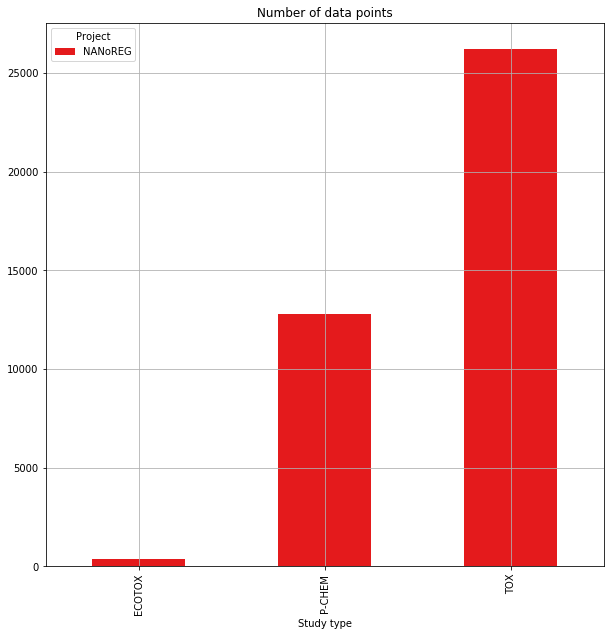

In [22]:
#use this to find where method field is missing
#table = pd.pivot_table(df, values=method_field, index=['topcategory_s','endpointcategory_name'], columns=[ 'owner_name_s'], aggfunc=lambda x: ' '.join(str(v) for v in x)).fillna("")
table = pd.pivot_table(df, values="Number of data points", index=['Study type'], columns=[ 'Project'], aggfunc=np.sum).fillna(0);
display(table)
p = table.plot(kind="bar",  figsize=(10,10) ,sharey =True,title="Number of data points", grid=True)
fig = p.get_figure()
fig.savefig("studytype_datapoints.png")

## Methods summary

In [23]:
#Methods summary
#table = pd.pivot_table(df, values=method_field, index=['Study type','endpointcategory_name'], columns=[ 'Project'], aggfunc=lambda x: ' '.join(str(v) for v in x)).fillna("")
table = pd.pivot_table(df, values=method_field, index=['Study type','endpointcategory_name'], columns=[ 'Project'], aggfunc=lambda x: ';'.join(set(str(v) for v in x))).fillna("")
table

Project                                                                                             NANoREG
Study type endpointcategory_name                                                                           
ECOTOX     Short-term toxicity to aquatic inverterbrates  SOP-Toxicity Test with Daphnia magna (without ...
           Toxicity to aquatic algae and cyanobacteria                    PSEUDOKIRCHNERIELLA SUBCAPITATA;_
           Toxicity to soil macroorganisms                ISO 10872:2010 Water QualityDetermination of t...
P-CHEM     Aerosol characterisation                                                                       _
           Analytical Methods                                                                             _
           Aspect ratio/shape                                                                             _
           Batch Dispersionquality                                                                    TEM;_
           Crystalline phase                                                                              _
           Crystallite and grain phase                                                                  XRD
           Density                                                                                        _
           Dustiness                                                      Vortex Shaker;vibrofluidization;_
           Particlesize distribution(Granulometry)                                       CFE;SEM;SAXS;CLS;_
           Solubility inorganic solvents                                                                  _
           Specific surface area                                                                          _
           Surface chemistry                                                                              _
           Water solubility                                                                               _
           Zeta potential                                                                                 _
TOX        Barrier integrity                              TEM/STEM;IN VITRO ORAL MUCOSA 3D MODEL;CONFOCA...
           CellViability                                  MTS CELL VIABILITY ASSAY;SPECTROPHOTOMETRIC ME...
           Genetic toxicity invitro                       RT-PCR;COMET;COMET FPG;p53 phospho s15;MICRONU...
           Genetic toxicity invivo                                             MICRONUCLEUS;COMET;COMET FPG
           Immunotoxicity                                 Annexin V (Apoptosis) / PI (Necrosis);ANNEXIN ...
           Oxidative Stress                                    DCFH2-DA;REACTION OXYGEN SPECIES DETECTION;_
           Repeated dose toxicity-inhalation              COMMERCIAL KITS;AUTOMATIC COUNT;MANUAL COUNT;M...
           Repeated dose toxicity-oral                    MANUAL COUNT;GREISS REAGENT;COMET;MAY GRUNWALD...

## Number of data points per material and project

Project,NANoREG
NM type,
(14)-beta-D-glucan,365
_,60
barium sulfate,1547
calcium carbonate,42
carbon nanotube,276
cerium oxide nanoparticle,2508
chemical substance,354
gold nanoparticle,5
graphite,6


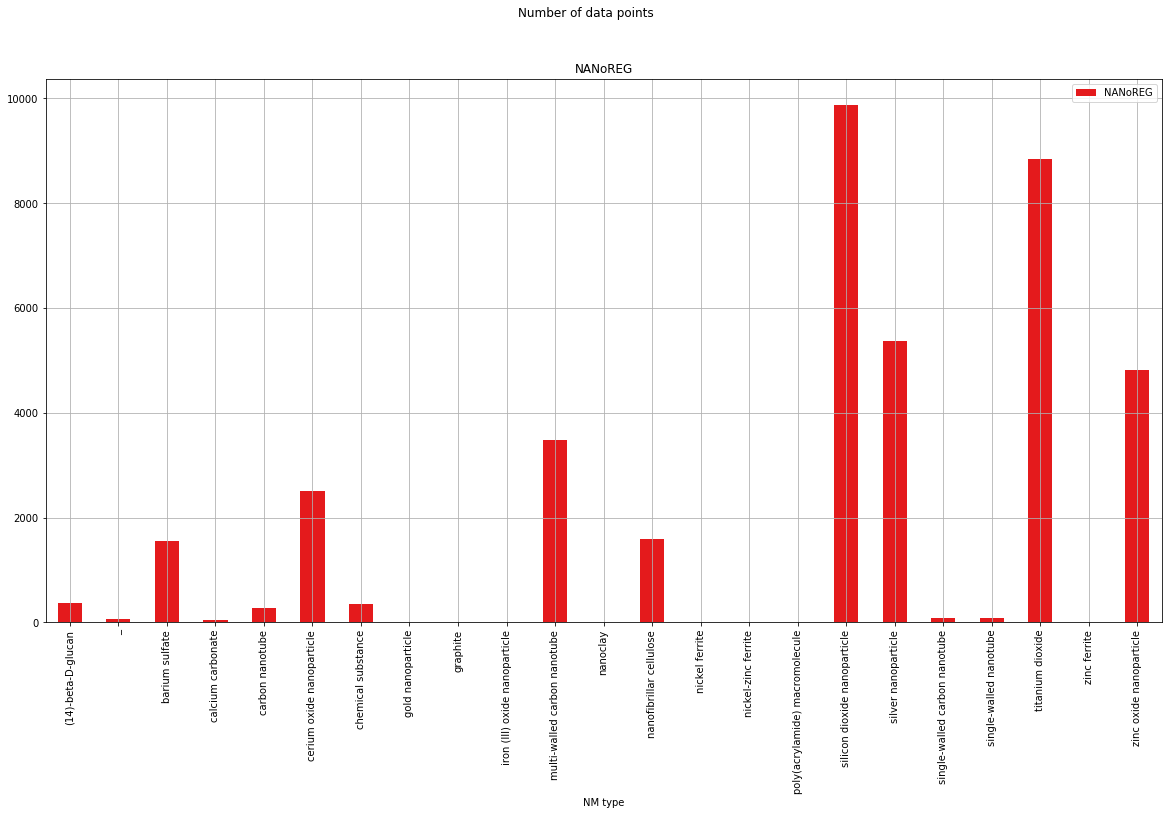

In [24]:
table = pd.pivot_table(df, values="Number of data points", index=['NM type'], columns=[ 'Project'], aggfunc=np.sum).fillna(0);
display(table)
p = table.plot(kind="bar",  figsize=(20,10) ,title="Number of data points", grid=True, stacked =False, sharey=True, subplots=True)
#fig = p.get_figure()
#fig.savefig("nmtype_datapoints.png")

## Number of data points per material and study type

NM type,(14)-beta-D-glucan,_,barium sulfate,calcium carbonate,carbon nanotube,cerium oxide nanoparticle,chemical substance,gold nanoparticle,graphite,iron (III) oxide nanoparticle,...,nickel ferrite,nickel-zinc ferrite,poly(acrylamide) macromolecule,silicon dioxide nanoparticle,silver nanoparticle,single-walled carbon nanotube,single-walled nanotube,titanium dioxide,zinc ferrite,zinc oxide nanoparticle
Study type,,,,,,,,,,,,,,,,,,,,,
ECOTOX,0.0,42.0,0.0,0.0,13.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,12.0,46.0,0.0,0.0,170.0,0.0,12.0
P-CHEM,126.0,18.0,546.0,42.0,87.0,985.0,127.0,5.0,6.0,13.0,...,6.0,6.0,10.0,2751.0,1819.0,14.0,51.0,3000.0,6.0,1595.0
TOX,239.0,0.0,1001.0,0.0,176.0,1511.0,227.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7116.0,3504.0,77.0,41.0,5676.0,0.0,3217.0


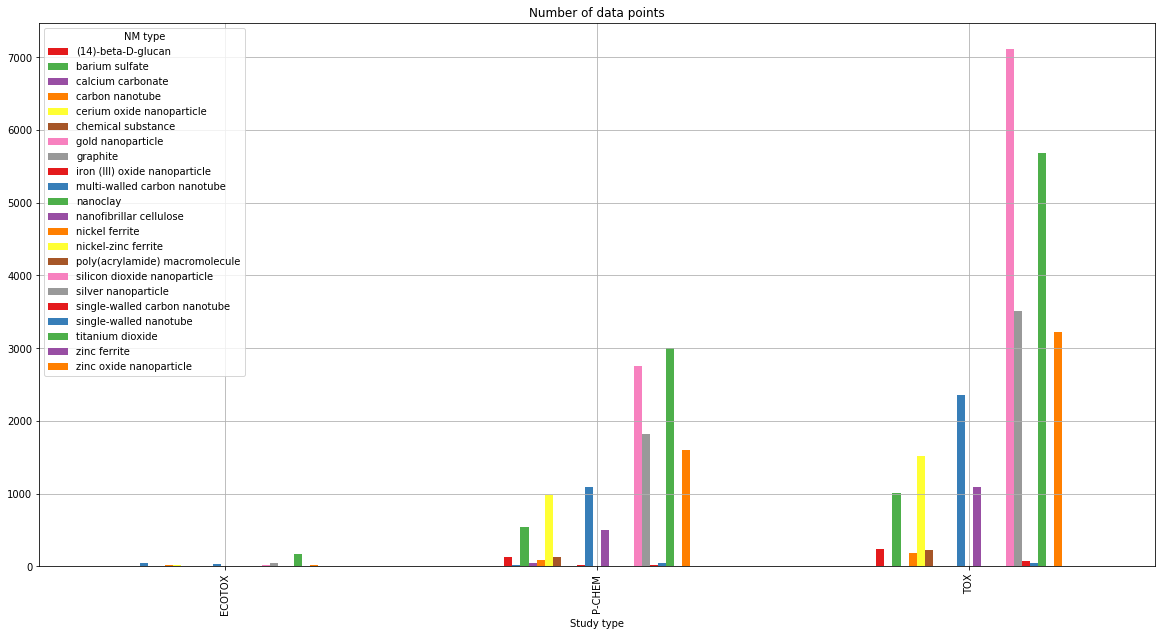

In [25]:
table = pd.pivot_table(df, values="Number of data points", columns=['NM type'], index=[ 'Study type'], aggfunc=np.sum).fillna(0);
display(table)
p = table.plot(kind="bar",  figsize=(20,10) ,title="Number of data points", grid=True, stacked =False, sharey=True, subplots=False)
#fig = p.get_figure()
#fig.savefig("nmtype_datapoints.png")

# Materials

In [26]:
import matplotlib.pyplot as plt
binary = ["#ff0000","#00ff00"]
sns.set_palette(binary)
#red/green palette
#sns.palplot(sns.color_palette())
  
def plot_heatmap(table,q):    
    sns.set_style('ticks')
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(10,10)
    #fig.set_size_inches(11.7/4, 8.27/4)
    sns_plot = sns.heatmap(table, cmap=binary)
    sns_plot.set_title(q)
    sns_plot.get_figure().savefig(q+".png")
    return (sns_plot)


In [27]:
df = summary(query="*:*",fq="type_s:substance",statistics="Number of NM", fields=["owner_name_hs","substanceType_hs","publicname_hs"])    
df.rename(columns={"owner_name_hs" : "Project","topcategory_s":"Study type","substanceType_name": "NM type"},inplace=True)

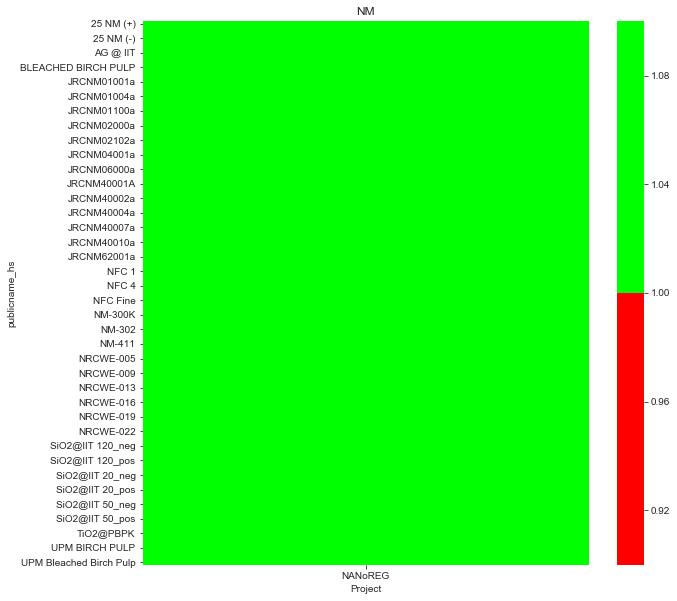

In [28]:
table = pd.pivot_table(df, values="Number of NM", index=['publicname_hs'], columns=[ 'Project'], aggfunc='any').fillna(False)
plot_heatmap(table,"NM")

# Endpoints

In [29]:
def queryEndpoints(_query="topcategory_s:TOX"):
    print(_query)
    df = summary(query=_query,fq="type_s:study",statistics="Number of data points", fields=["topcategory_s","endpointcategory_s","effectendpoint_s","substanceType_s","publicname_s"])        
    df.rename(columns={"owner_name_s" : "Project","topcategory_s":"Study type","substanceType_name": "NM type","endpointcategory_name":"endpoint"},inplace=True)
    table = pd.pivot_table(df, values="Number of data points", index=['NM type'], columns=['endpoint' ], aggfunc='any').fillna(False)
    return (df,table)



topcategory_s:TOX


endpoint,Barrier integrity,CellViability,Genetic toxicity invitro,Genetic toxicity invivo,Immunotoxicity,Oxidative Stress,Repeated dose toxicity-inhalation,Repeated dose toxicity-oral
NM type,,,,,,,,
(14)-beta-D-glucan,False,True,True,True,True,False,True,False
barium sulfate,False,True,True,False,True,True,False,False
carbon nanotube,False,False,True,False,False,False,False,True
cerium oxide nanoparticle,True,True,True,False,True,True,True,False
chemical substance,False,True,True,False,True,False,False,False
multi-walled carbon nanotube,True,True,True,True,True,True,False,True
nanofibrillar cellulose,False,True,True,True,True,False,True,True
silicon dioxide nanoparticle,True,True,True,False,True,True,False,True
silver nanoparticle,True,True,True,False,True,True,False,False


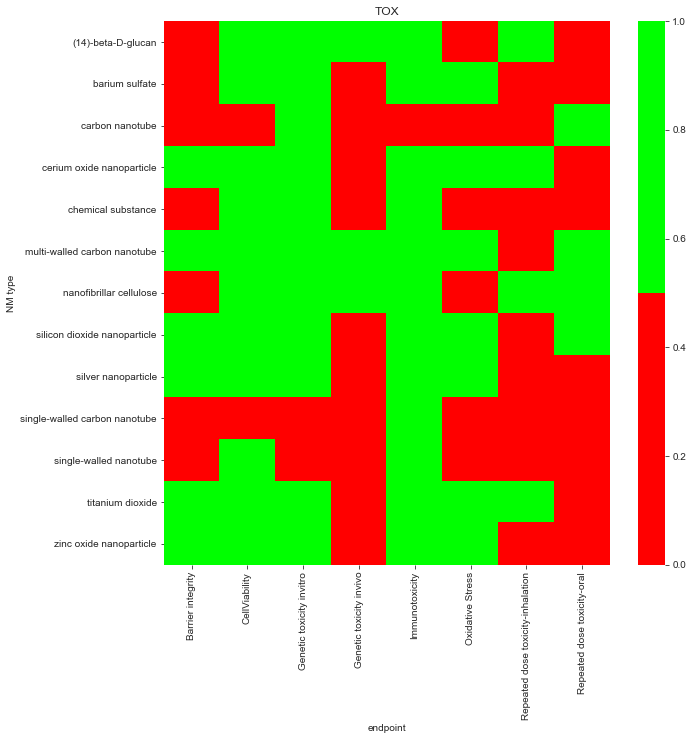

In [30]:
q="TOX"
df,table=queryEndpoints(_query="topcategory_s:"+q)
display(table)
plot_heatmap(table,q)

topcategory_s:P-CHEM


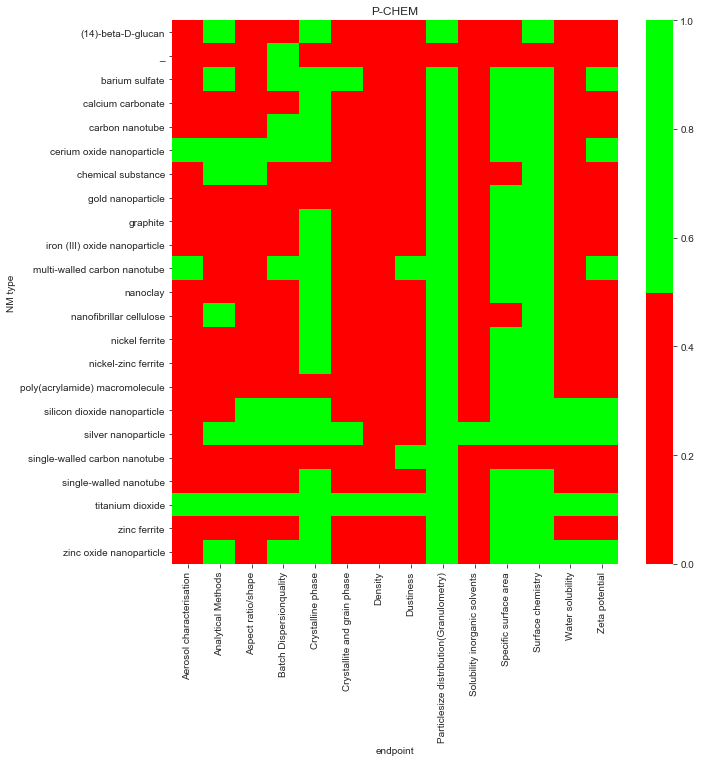

In [31]:
q="P-CHEM"
df,table=queryEndpoints(_query="topcategory_s:"+q)
plot_heatmap(table,q)

topcategory_s:ECOTOX


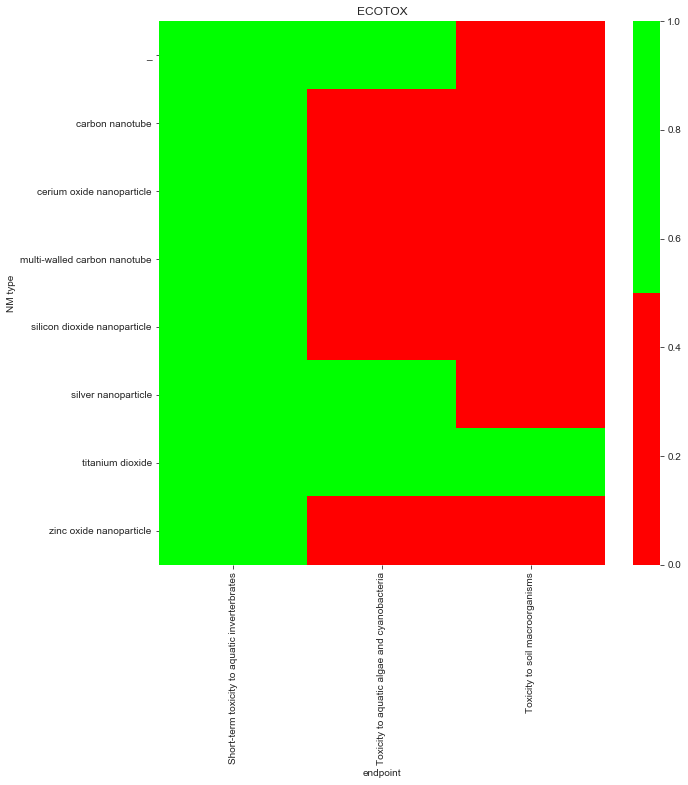

In [32]:
q="ECOTOX"
df,table=queryEndpoints(_query="topcategory_s:"+q)
plot_heatmap(table,q)